## Plotting
### Used to visuals districting plans, plan demographics, and plan scores.

In [1]:
from gerrytools.scoring import *
from gerrytools.plotting import *
import pandas as pd
import geopandas as gpd
from gerrychain import Graph
import json
import matplotlib.pyplot as plt

In [2]:
plan = gpd.read_file("data/GA_CD_example")

There are functions that allow us to visualize a districting plan, as well as draw a choropleth for a certain demographic within the plan, or a dot density map of the plan. 

First we'll start with `drawplan`. In order to use this, you will need your desired plan as a shapefile on any units with a dedicated column for districts. This function also allows us to overlay other geographies on the plan. In this case, we're plotting a plan for the GA Congressional map, and we'll overlay the plan with Georgia counties. 

This function automatically plots the plan using districtr colors, a list of 33 colors, so if the plan has more than 33 districts, there will be repeats. A user defined color list can be passed using the `colors` argument, which is for the name of a column that defines color on the shapefile.

In [3]:
ga_county = gpd.read_file("http://data.mggg.org.s3-website.us-east-2.amazonaws.com/census-2020/ga/ga_county.zip")

In [4]:
ga_county.columns

Index(['NBAPAVAP20', 'FUNCSTAT20', 'STATEFP20', 'BVAP20', 'LOGRECNO',
       'AMINVAP20', 'COUNTYFP20', 'WPOP20', 'STUSAB', 'DOJBVAP20',
       'APAMIVAP20', 'COPOP20', 'APAMIPOP20', 'HVAP20', 'HISP20', 'ASIANPOP20',
       'NAMELSAD20', 'NHPIPOP20', 'APBPOP20', 'NAME20', 'AWATER20',
       'ASIANVAP20', 'WVAP20', 'MTFCC20', 'OTHERVAP20', 'CHARITER',
       '2MOREVAP20', 'APAPOP20', 'GEOID20', 'SUMLEV', 'CIFSN', '2MOREPOP20',
       'CLASSFP20', 'APAVAP20', 'AMINPOP20', 'INTPTLAT20', 'NWBHPOP20',
       'NWBHVAP20', 'TOTPOP20', 'VAP20', 'CSAFP20', 'GEOCODE', 'COUNTYNS20',
       'LSAD20', 'FILEID', 'BPOP20', 'OTHERPOP20', 'NHPIVAP20', 'ALAND20',
       'APBVAP20', 'CBSAFP20', 'INTPTLON20', 'METDIVFP20', 'NBAPAPOP20',
       'COVAP20', 'geometry'],
      dtype='object')

In [5]:
new_plan = plan.dissolve(by="CD")
new_plan= new_plan.reset_index()
new_plan["CD"]

0     01
1     02
2     03
3     04
4     05
5     06
6     07
7     08
8     09
9     10
10    11
11    12
12    13
13    14
Name: CD, dtype: object

In [6]:
import matplotlib.pyplot as plt
import gerrytools.plotting.colors as colors
import numpy as np


N = len(new_plan)

dists = new_plan.to_crs("EPSG:3857")
dists["CD"] = dists["CD"].astype(int)
dists=dists.sort_values(by="CD")
dists["colorindex"] = list(range(N))
dists["color"] = colors.districtr(N)
dists[["color", "CD", "colorindex"]]

,color,CD,colorindex
0,#0099cd,1,0
1,#ffca5d,2,1
2,#00cd99,3,2
3,#99cd00,4,3
4,#cd0099,5,4
5,#9900cd,6,5
6,#8dd3c7,7,6
7,#bebada,8,7
8,#fb8072,9,8
9,#80b1d3,10,9


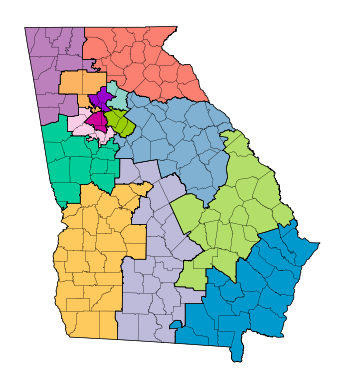

In [7]:
ax = drawplan(plan, assignment="CD",overlays=[ga_county])

We can also draw a choropleth of a certain demographic across the map. Our `drawchoropleth` function takes care of this, so long as you pass a demographic share column.

You can also pass the column of total counts of any demographic share. This function plots the map, as well as a colorbar, whose label can be changed the the `cbartitle` argument.

In [8]:
plan.columns

Index(['ID', 'DISTRICT', 'PRECINCT_I', 'PRECINCT_N', 'CTYNAME', 'FIPS1',
       'FIPS2', 'PRES16D', 'PRES16R', 'PRES16L', 'SEN16D', 'SEN16R', 'SEN16L',
       'TOTPOP', 'NH_WHITE', 'NH_BLACK', 'NH_AMIN', 'NH_ASIAN', 'NH_NHPI',
       'NH_OTHER', 'NH_2MORE', 'HISP', 'H_WHITE', 'H_BLACK', 'H_AMIN',
       'H_ASIAN', 'H_NHPI', 'H_OTHER', 'H_2MORE', 'VAP', 'HVAP', 'WVAP',
       'BVAP', 'AMINVAP', 'ASIANVAP', 'NHPIVAP', 'OTHERVAP', '2MOREVAP', 'CD',
       'HDIST', 'SEND', 'geometry'],
      dtype='object')

In [9]:
plan["VAP_CD"] = plan.groupby("CD")["VAP"].transform("sum")
plan["BVAP_SHARE_CD"] = plan["BVAP"]/plan["VAP_CD"]
plan["APB_share"] = (
    plan["BVAP"]
    +plan["HVAP"]
    +plan["ASIANVAP"]
    )/plan["VAP_CD"]
plan["WVAP_share"] = plan["WVAP"]/plan["VAP_CD"]
plan["BVAP_SHARE_LOCAL"] = plan["BVAP"]/plan["VAP"]

/home/peter/Dropbox/MGGG/Git_Repos/gerrytools-dev/gerrytools/plotting/choropleth.py:86: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colorbarmap = plt.cm.get_cmap(cmap, len(boundaries))


<Figure size 640x480 with 0 Axes>

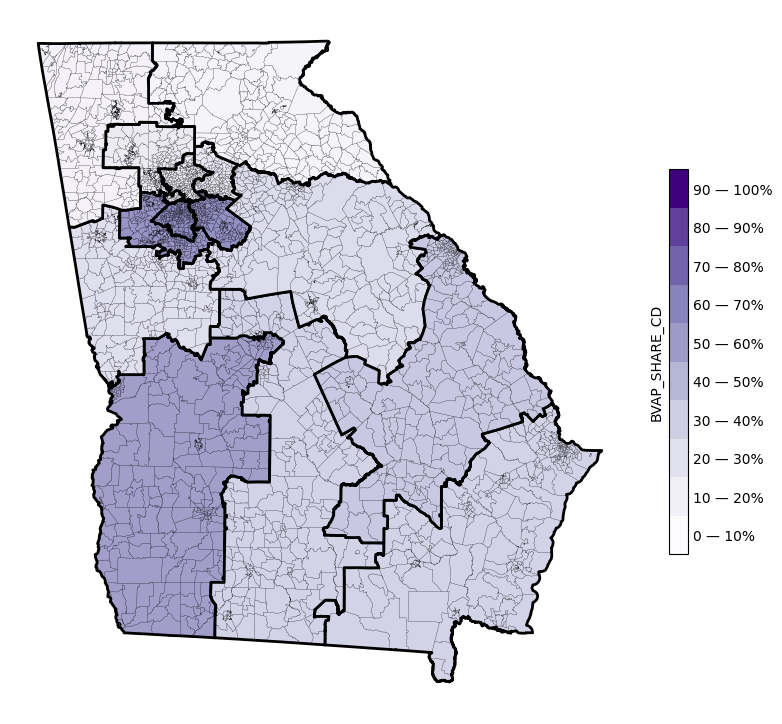

In [10]:
plt.clf()
choro = choropleth(
    plan, 
    districts=plan,
    assignment="CD",
    demographic_share_col="BVAP_SHARE_CD",
    overlays=[], 
    cmap="Purples", 
    district_lw=0.1,
    base_lw=2,
    base_linecolor="black",
) 

We can also plot scores across an ensemble of plans. And there's a variety of plots we've built in, this includes `histogram`, `boxplot`, and `violin` plots.

In [11]:
scores = json.load(open("data/ensemble_example.json"))

/tmp/ipykernel_724348/4236712860.py:1: ResourceWarning: unclosed file <_io.TextIOWrapper name='data/ensemble_example.json' mode='r' encoding='UTF-8'>
  scores = json.load(open("data/ensemble_example.json"))


We'll start with the `histogram` function. This works by taking a dictionary with a list of scores from an ensemble, a list of scores from "citizen" maps, and a list of scores from "proposed" maps. The citizen maps will get plotted as a histogram on the same axis as the ensemble scores, while the proposed maps will appear as vertical bars with one score per plan. 

In this example, we'll plot the number of majority Black districts in an ensemble, along with one proposed map. 

When using proposed maps, the argument `proposed_info` also has to be used. Passed to this argument is a dictionary with the keys `names` and `colors`, these will be 2 lists with the names of the proposed plans, and the desired color for their vertical line, respectively. 

In [12]:
scores

[{'APBVAP20': [0.4550999248117719,
   0.5896167004461698,
   0.663878394956413,
   0.40236907624720647,
   0.5012400691649247,
   0.2725579577362449],
  'COLVAP20': [0.5075617384616969,
   0.6750984043345205,
   0.776546670241374,
   0.44993414511866625,
   0.6362636635594903,
   0.46271311860143083],
  'HVAP20': [0.052461813649924985,
   0.08548170388835072,
   0.11266827528496104,
   0.04756506887145977,
   0.13502359439456552,
   0.19015516086518594],
  'WVAP20': [0.4573006396149264,
   0.29420574958089474,
   0.20344471796371671,
   0.5115165316995658,
   0.27118086413240755,
   0.4187572765584989],
  'effectiveness': 4,
  'step': 0},
 {'APBVAP20': [0.4550999248117719,
   0.5896167004461698,
   0.663878394956413,
   0.40236907624720647,
   0.31157996069150856,
   0.4530769086003569],
  'COLVAP20': [0.5075617384616969,
   0.6750984043345205,
   0.776546670241374,
   0.44993414511866625,
   0.5375863470134092,
   0.5553114718759142],
  'HVAP20': [0.052461813649924985,
   0.0854817038

In [13]:
score_dict = {"ensemble":[], "citizen":[], "proposed":[]}

In [14]:
for score in scores:
    score_dict["ensemble"].append(len([apb for apb in score["APBVAP20"] if apb > 0.5]))

In [15]:
score_dict

{'ensemble': [3,
  2,
  3,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  3,
  2,
  2,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  2,
  3,
  3,
  3,
  4,
  4,
  4,
  3,
  3,
  4,
  4,
  3,
  3,
  4,
  4,
  4,
  3,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  3,
  2,
  2,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  4,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  4,
  4,
  4,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  4,
  4,
  3,
  3,
  3,
  3,
  3,
  3,
  4,
  3,
  3,
  3,
  3,
  3,
  2,
  2,
  2,
  2,
  2,
  2,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  2,
  2,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2

In [16]:
condensed_plan = plan[[
    "CD", 
    "APB_share",
    "BVAP_SHARE_CD",
    "WVAP_share",
    plan.geometry.name
]].dissolve(
    by="CD",
    aggfunc="sum"
)

In [17]:
condensed_plan

,geometry,APB_share,BVAP_SHARE_CD,WVAP_share
CD,,,,
01,"POLYGON ((-82.03673 30.38437, -82.03697 30.384...",0.345534,0.280139,0.637733
02,"POLYGON ((-84.86380 30.71151, -84.86413 30.711...",0.536381,0.485516,0.451065
03,"POLYGON ((-85.08504 32.63084, -85.08494 32.631...",0.277007,0.217714,0.709667
04,"POLYGON ((-84.24440 33.63074, -84.24545 33.630...",0.672932,0.546767,0.309492
05,"POLYGON ((-84.47244 33.62845, -84.47358 33.627...",0.664869,0.555584,0.317314
06,"MULTIPOLYGON (((-84.45641 33.88496, -84.45713 ...",0.333238,0.122086,0.648133
07,"POLYGON ((-84.16045 33.88220, -84.16133 33.882...",0.453038,0.166550,0.529848
08,"POLYGON ((-84.08275 30.73615, -84.08273 30.736...",0.341145,0.279060,0.646560
09,"POLYGON ((-84.25846 34.30353, -84.25845 34.303...",0.162860,0.062876,0.826171


In [18]:
score_dict["proposed"].append(len(condensed_plan[condensed_plan.BVAP_SHARE_CD > 0.5]))

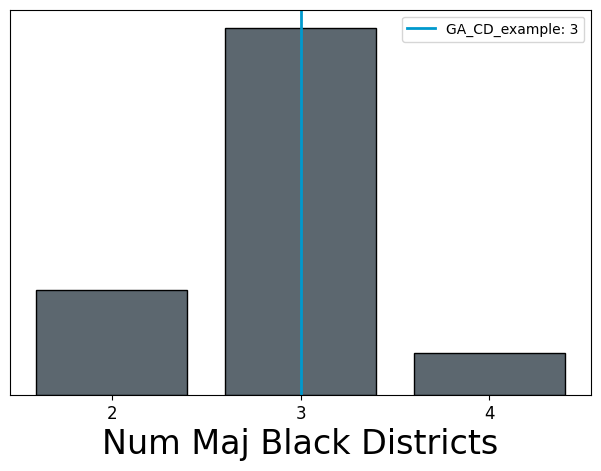

In [19]:
fig, ax = plt.subplots(1, 1, figsize = (7.5, 5))
hist = histogram(
    ax, 
    score_dict, 
    label = "Num Maj Black Districts", 
    proposed_info={"names": ["GA_CD_example"]}
)

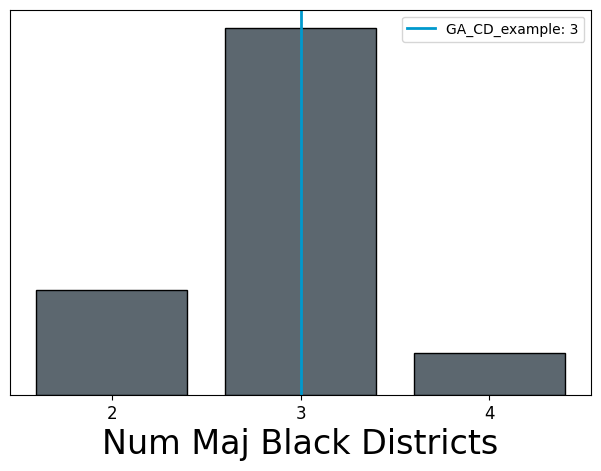

In [20]:
hist.figure

Next we'll look at the `boxplot` function. Similarly to the `histogram` the scores are passed as a dictionary. However, ensemble scores must already be a lits of lists where each individual list represents the values for that box. This means that prior to plotting, scores must already be sorted and grouped so that scores are plotted lowest to highest. 

Proposed plans wlll also be a list of lists. Each proposed plan list will be of length one with one score per box. An example of pre-processing to get scores in both of these formats can be seen below. 

In [21]:
for score in scores:
    print(score)

{'APBVAP20': [0.4550999248117719, 0.5896167004461698, 0.663878394956413, 0.40236907624720647, 0.5012400691649247, 0.2725579577362449], 'COLVAP20': [0.5075617384616969, 0.6750984043345205, 0.776546670241374, 0.44993414511866625, 0.6362636635594903, 0.46271311860143083], 'HVAP20': [0.052461813649924985, 0.08548170388835072, 0.11266827528496104, 0.04756506887145977, 0.13502359439456552, 0.19015516086518594], 'WVAP20': [0.4573006396149264, 0.29420574958089474, 0.20344471796371671, 0.5115165316995658, 0.27118086413240755, 0.4187572765584989], 'effectiveness': 4, 'step': 0}
{'APBVAP20': [0.4550999248117719, 0.5896167004461698, 0.663878394956413, 0.40236907624720647, 0.31157996069150856, 0.4530769086003569], 'COLVAP20': [0.5075617384616969, 0.6750984043345205, 0.776546670241374, 0.44993414511866625, 0.5375863470134092, 0.5553114718759142], 'HVAP20': [0.052461813649924985, 0.08548170388835072, 0.11266827528496104, 0.04756506887145977, 0.22600638632190062, 0.10223456327555736], 'WVAP20': [0.457

In [22]:
boxplot_score_dict = {"ensemble": [], "proposed": [], "citizen": []}
first_time = True
for score in scores:
    if first_time:
        for s in sorted(score["APBVAP20"]):
            boxplot_score_dict["ensemble"].append([s])
        first_time = False
    else:
        for i, s in enumerate(sorted(score["APBVAP20"])):
            boxplot_score_dict["ensemble"][i].append(s)
boxplot_score_dict["proposed"] = ([[k] for k in sorted(condensed_plan.APB_share)])

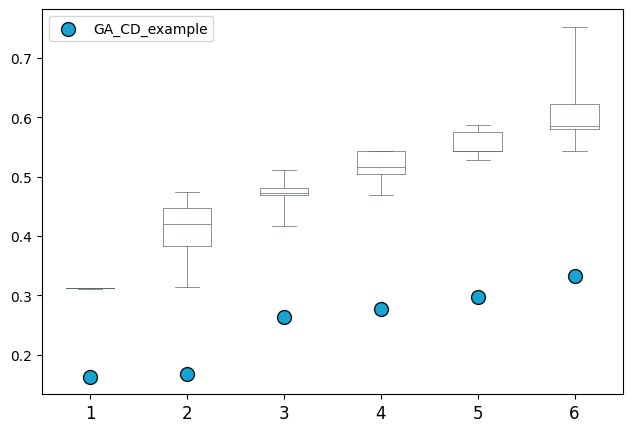

In [23]:
fig, box_ax = plt.subplots(1, 1, figsize = (7.5, 5))
box_plot = boxplot(box_ax, boxplot_score_dict, proposed_info={"names": ["GA_CD_example"], "colors": ["olivedrab"]})

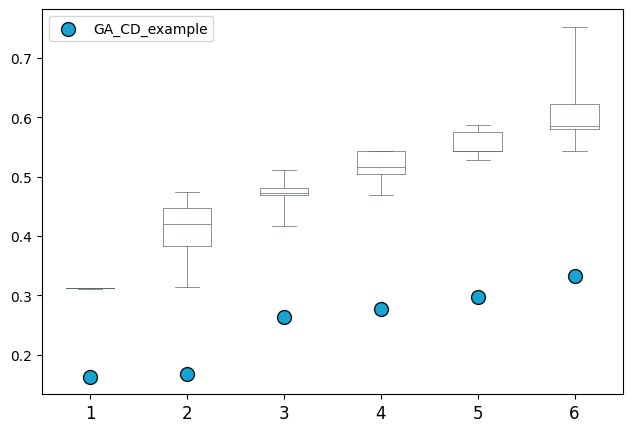

In [24]:
box_plot.figure

Another type of plot, similar to the boxplot, is a violin plot. These show the same information as boxplots, however, rather than data being displayed in boxes, rotated kernel densities are shown, and in some instances look like violins!

The `violin` function allows us to make this plot. These takes the same score format as boxplots. In these example, we also show the use of other parameters like `rotation` which is a float that specifies the rotation of x axis labels. Next, we can actually define a list of 2 labels (1 for x-axis, 1 for y-axis) to be displayed on the plot. 

In [25]:
boxplot_score_dict["proposed"]

[[0.16286005808021348],
 [0.1683124936144796],
 [0.26379211540361625],
 [0.27700715079253313],
 [0.2968300826069221],
 [0.33323844694545435],
 [0.341145164320689],
 [0.3455340467906047],
 [0.38650642898889537],
 [0.45303759620834394],
 [0.5363812424862094],
 [0.6368328003019408],
 [0.6648685210858191],
 [0.6729322712006883]]

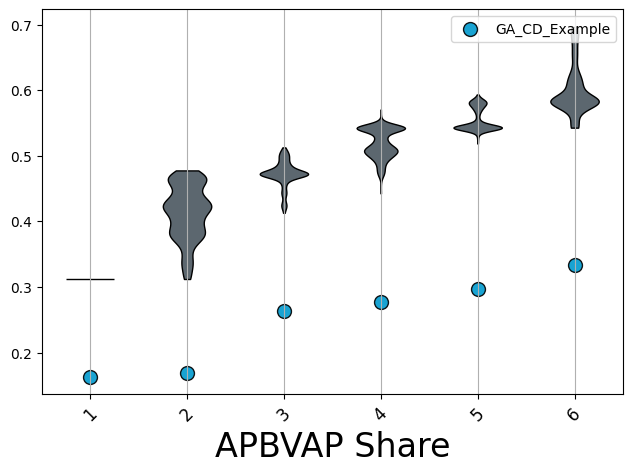

In [26]:
fig, violin_ax = plt.subplots(1, 1, figsize = (7.5, 5))
violin_plot = violin(
    violin_ax,
	boxplot_score_dict,
	rotation=45,
	labels=[
        "APBVAP Share",
        ""
    ],
	proposed_info={"names":["GA_CD_Example"],
	"colors":["olivedrab"]}
)

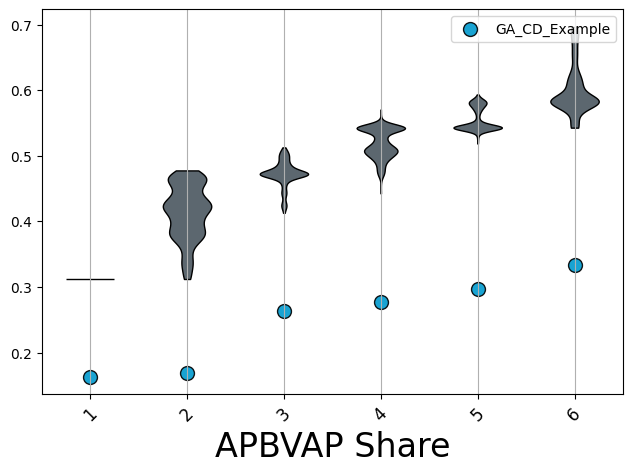

In [27]:
violin_plot.figure

Moving away from visualizing ensembles, we can visualize specific scores about individual plans. Both the `sealevel` and `scatter` functions can be used to accomplish this. We'll start with `scatter1`. 

This function can be used to compare 2 scores across a plan, an ensemble, etc. 

Here, we'll compare the APBVAP20_share in each district of our example plan, and the WVAP20_share in each district of our example plan. 

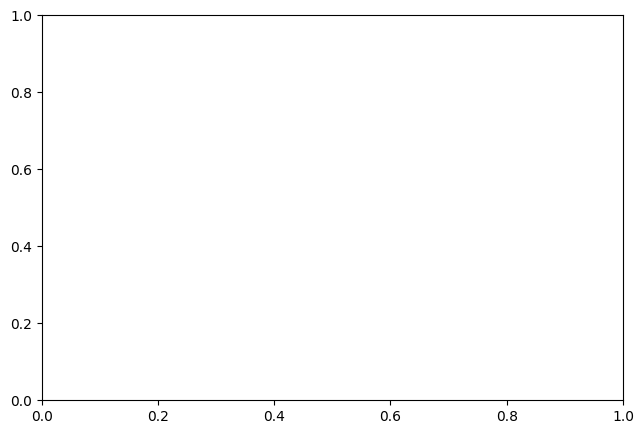

In [28]:
fig, scatter_ax = plt.subplots(1, 1, figsize = (7.5, 5))

In [29]:
plan.columns

Index(['ID', 'DISTRICT', 'PRECINCT_I', 'PRECINCT_N', 'CTYNAME', 'FIPS1',
       'FIPS2', 'PRES16D', 'PRES16R', 'PRES16L', 'SEN16D', 'SEN16R', 'SEN16L',
       'TOTPOP', 'NH_WHITE', 'NH_BLACK', 'NH_AMIN', 'NH_ASIAN', 'NH_NHPI',
       'NH_OTHER', 'NH_2MORE', 'HISP', 'H_WHITE', 'H_BLACK', 'H_AMIN',
       'H_ASIAN', 'H_NHPI', 'H_OTHER', 'H_2MORE', 'VAP', 'HVAP', 'WVAP',
       'BVAP', 'AMINVAP', 'ASIANVAP', 'NHPIVAP', 'OTHERVAP', '2MOREVAP', 'CD',
       'HDIST', 'SEND', 'geometry', 'VAP_CD', 'BVAP_SHARE_CD', 'APB_share',
       'WVAP_share', 'BVAP_SHARE_LOCAL'],
      dtype='object')

In [30]:
condensed_plan

,geometry,APB_share,BVAP_SHARE_CD,WVAP_share
CD,,,,
01,"POLYGON ((-82.03673 30.38437, -82.03697 30.384...",0.345534,0.280139,0.637733
02,"POLYGON ((-84.86380 30.71151, -84.86413 30.711...",0.536381,0.485516,0.451065
03,"POLYGON ((-85.08504 32.63084, -85.08494 32.631...",0.277007,0.217714,0.709667
04,"POLYGON ((-84.24440 33.63074, -84.24545 33.630...",0.672932,0.546767,0.309492
05,"POLYGON ((-84.47244 33.62845, -84.47358 33.627...",0.664869,0.555584,0.317314
06,"MULTIPOLYGON (((-84.45641 33.88496, -84.45713 ...",0.333238,0.122086,0.648133
07,"POLYGON ((-84.16045 33.88220, -84.16133 33.882...",0.453038,0.166550,0.529848
08,"POLYGON ((-84.08275 30.73615, -84.08273 30.736...",0.341145,0.279060,0.646560
09,"POLYGON ((-84.25846 34.30353, -84.25845 34.303...",0.162860,0.062876,0.826171


In [31]:
scatter_plot = scatterplot(
    scatter_ax, 
    x=[list(condensed_plan["APB_share"])], 
    y=[list(condensed_plan["WVAP_share"])], 
    labels = ["APBVAP Share", "WVAP Share"]
)

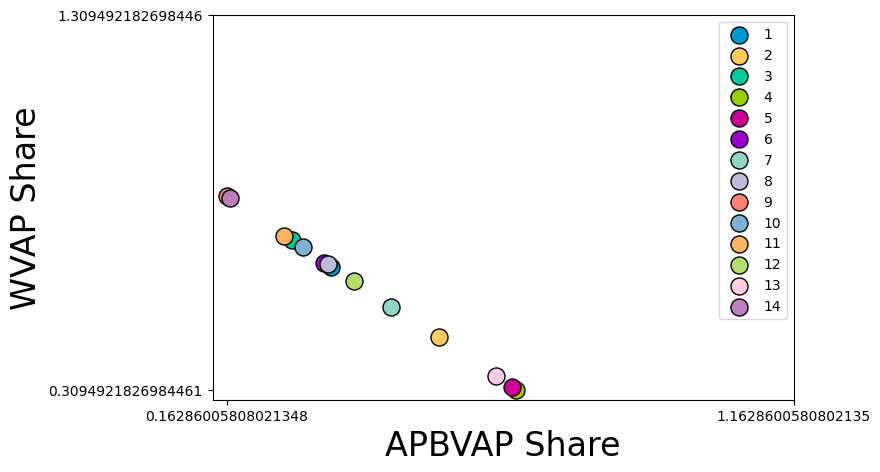

In [32]:
scatter_plot.figure